Use `word2vec` embeddings as text representation.

# Reading Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
%matplotlib inline

In [2]:
data = pd.read_csv('./data/rotten_tomatoes_20200726.csv', 
                            index_col=0,header=0, 
                            encoding = "utf8")
data.head(2)

,text,Action and Adventure,Animation,Art House and International,Comedy,Drama,Horror,Kids and Family,Musical and Performing Arts,Mystery and Suspense,Romance,Science Fiction and Fantasy,fresh,rotten,Other
0,A distinctly gallows take on contemporary fina...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1,0,0
1,It's an allegory in search of a meaning that n...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0,1,0


In [3]:
data.shape

(48755, 15)

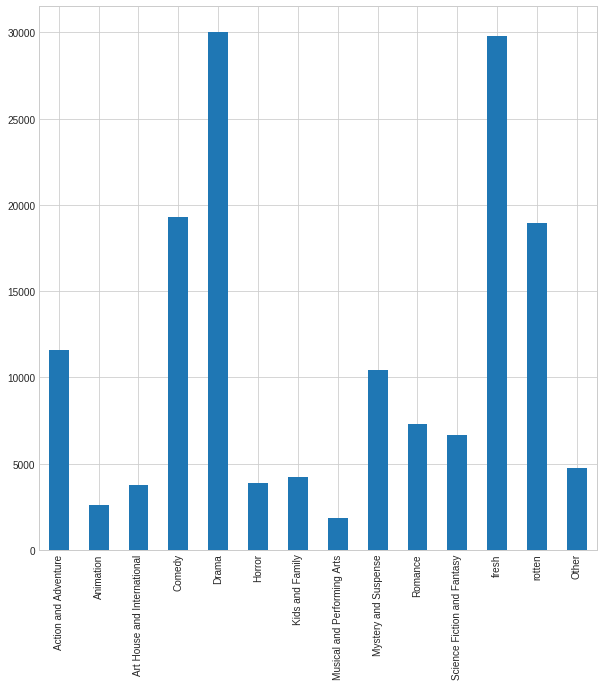

In [4]:
plt.figure(figsize=(10, 10))
data.iloc[:, 1:].sum(axis = 0, skipna = True).plot(kind='bar')

In [5]:
y_df = data.iloc[:, 1:]

In [6]:
tags = list(y_df.columns)
tags

['Action and Adventure',
 'Animation',
 'Art House and International',
 'Comedy',
 'Drama',
 'Horror',
 'Kids and Family',
 'Musical and Performing Arts',
 'Mystery and Suspense',
 'Romance',
 'Science Fiction and Fantasy',
 'fresh',
 'rotten',
 'Other']

In [7]:
Y = y_df.values
Y[:5]

array([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0.]])

# Text Preprocessing

In [9]:
import textacy
#import en_core_web_sm
nlp = textacy.load_spacy_lang("en_core_web_md")

import re

## Identify NERs

In [10]:
def ner_replace(text):
    doc = textacy.make_spacy_doc(text,lang=nlp)
    entities={}
    for i in doc.ents:
        entities[str(i)] = i.label_
    new_doc = doc.text
    for k in sorted(entities.keys(), key = len, reverse = True):
        new_doc = new_doc.replace(k, entities[k])
    return(new_doc)

## Identify MWPs

In [11]:
import textacy.ke
def np_replace(text):
    doc = textacy.make_spacy_doc(text,lang=nlp)
    chunk_lst = [t[0] for t in (textacy.ke.textrank(doc, normalize="lemma", topn=10)) if (len(t[0]) > 1)]
    replace_lst = ['_'.join(t.split()) for t in chunk_lst]

    replace_dict = dict(zip(chunk_lst, replace_lst))

    new_doc = doc.text
    for k in sorted(replace_dict.keys(), key = len, reverse = True):
        new_doc = new_doc.replace(k, replace_dict[k])
    return(new_doc)

/home/tao/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:17: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping, defaultdict


## Clean Text
- Remove HTML tags
- Remove Punctuation
- Remove Non-alph tokens

In [12]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import re
import sys
import warnings
#data = sent_df1
if not sys.warnoptions:
    warnings.simplefilter("ignore")
def cleanHtml(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(sentence))
    return cleantext
def cleanPunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    cleaned = cleaned.strip()
    cleaned = cleaned.replace("\n"," ")
    return cleaned
def keepAlpha(sentence):
    alpha_sent = ""
    for word in sentence.split():
        alpha_word = re.sub('[^a-z A-Z]+', ' ', word)
        alpha_sent += alpha_word
        alpha_sent += " "
    alpha_sent = alpha_sent.strip()
    return alpha_sent

In [13]:
review_text = data.text

review_text = review_text.str.lower()

review_text = review_text.apply(cleanHtml)
review_text = review_text.apply(cleanPunc)
review_text = review_text.apply(ner_replace)
review_text = review_text.apply(np_replace)
review_text = review_text.apply(keepAlpha)

## Remove Stopwords

In [14]:
stop_words = set(stopwords.words('english'))
stop_words.update(['zero','one','two','three','four','five','six',
                   'seven','eight','nine','ten','may','also','across','among','beside','however','yet','within'])
re_stop_words = re.compile(r"\b(" + "|".join(stop_words) + ")\\W", re.I)
def removeStopWords(sentence):
    global re_stop_words
    return re_stop_words.sub(" ", sentence)

In [15]:
review_text = review_text.apply(removeStopWords)

## Stemming

In [16]:
stemmer = SnowballStemmer("english")
def stemming(sentence):
    stemSentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stemSentence += stem
        stemSentence += " "
    stemSentence = stemSentence.strip()
    return stemSentence

In [17]:
review_text = review_text.apply(stemming)

In [18]:
review_text.head(2)

0    distinct gallow take contemporari financi more...
1    allegori search mean never arriv old fashicard...
Name: text, dtype: object

In [19]:
review_text.apply(len).max()

579

In [20]:
from sklearn.model_selection import train_test_split
text_train, text_test, y_train, y_test = train_test_split(review_text, Y, test_size=0.2, 
                                                    random_state=2020)

In [22]:
text_test.head()

13178    whether your attun ador anim environment issu ...
3724     org great personbut pictur lose focus becom pr...
44791    battl date clear featur lot brilliant dancer i...
35709    org elev bond genr new level list refin game c...
42328    movi perfect captur vibe person place time way...
Name: text, dtype: object

In [39]:
y_test[:5]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.],
       [1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.]])

In [66]:
y_test_df = pd.DataFrame(y_test, index=text_test.index)
y_test_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
13178,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3724,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
44791,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
35709,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
42328,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [80]:
test_df = pd.concat([text_test, y_test_df], axis=1)
test_df.shape

(9751, 15)

In [81]:
test_df.head()

,text,0,1,2,3,4,5,6,7,8,9,10,11,12,13
13178,whether your attun ador anim environment issu ...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3724,org great personbut pictur lose focus becom pr...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
44791,battl date clear featur lot brilliant dancer i...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
35709,org elev bond genr new level list refin game c...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
42328,movi perfect captur vibe person place time way...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [82]:
#y_test_df = pd.DataFrame(y_test)
test_df = test_df.astype('int', errors='ignore')
test_df = test_df.astype('str', errors='ignore')
test_df.dtypes

text    object
0       object
1       object
2       object
3       object
4       object
5       object
6       object
7       object
8       object
9       object
10      object
11      object
12      object
13      object
dtype: object

In [83]:
test_df.iloc[0,1:].values

array(['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0',
       '1'], dtype=object)

In [84]:
test_df['labels'] = test_df.apply(lambda row: ''.join(row[1:].values), axis=1)
test_df['labels'].head()

13178    00000000000101
3724     00001000000011
44791    00001001000011
35709    10000000100100
42328    10011000000100
Name: labels, dtype: object

In [85]:
test_df['labels'].value_counts()

00001000000100    914
00011000000100    557
00010000000010    461
00001000000010    455
00010000000100    369
00001000100100    350
00011000000010    222
00001000010100    210
00011000010100    194
10001000100100    193
00001000100010    184
00010000010100    179
00011000010010    157
10000000001100    149
10000000001010    149
00101000000100    127
10001000100010    123
10000000100100    120
10001000000010    108
10001000000100    100
00001000010010     97
00010000010010     97
00000100000010     84
00111000000100     79
01010010000100     74
00001001000100     73
10000000100010     72
00001000000101     66
00000100100010     66
10001000000101     63
                 ... 
00010000100011      1
00101000010011      1
00000100101101      1
10101000100010      1
00100100001010      1
10110000000010      1
10111000000010      1
10001000101010      1
10000000010101      1
00100100001100      1
10010001010011      1
00001000001011      1
00010000101101      1
00110000000100      1
1000101000

In [86]:
import numpy as np
comedydramafresh = test_df[test_df.labels == '00011000000100'].text
# selected_idx = np.sort(np.random.choice(comedydramafresh.index.values, 50))
# selected_idx
comedydramafresh.shape

(557,)

In [87]:
text_test.isnull().any()

False

In [89]:
comedydramafresh.isnull().any()

False

In [90]:
import pickle

file_path = './data/processed.pickle'
with open(file_path, 'wb') as pickle_file:
    pickle.dump(text_train, pickle_file)
    pickle.dump(y_train, pickle_file)
    pickle.dump(text_test, pickle_file)
    pickle.dump(y_test, pickle_file)
    pickle.dump(comedydramafresh, pickle_file)

# Modeling

With keras `embedding` layer

In [8]:
import pickle

file_path = './data/processed.pickle'
with open(file_path, 'rb') as pickle_file:
    text_train = pickle.load(pickle_file)
    y_train = pickle.load(pickle_file)
    text_test = pickle.load(pickle_file)
    y_test = pickle.load(pickle_file)
    comedydramafresh = pickle.load(pickle_file)

In [9]:
comedydramafresh.head()

44403    laugh way team gpe team gpe intern polic forc ...
41733    master human comedi sincer drama imagin unpred...
1438     norp delight journalist person dazzl personper...
8107     person toss comed moment tension get intens do...
28561    film intellig beauti act movi group peopl sear...
Name: text, dtype: object

In [10]:
import tensorflow as tf
from tensorflow.keras.preprocessing import text
import keras.backend.tensorflow_backend as K
from keras import backend as K
import tensorflow as tf
with K.tf.device('/gpu:2'):
    config = tf.ConfigProto(intra_op_parallelism_threads=4,\
           inter_op_parallelism_threads=4, allow_soft_placement=True,\
           device_count = {'CPU' : 1, 'GPU' : 1})
    session = tf.Session(config=config)
    K.set_session(session)

/home/tao/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/tao/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/tao/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/tao/anaconda3/envs/tf_gpu/lib/python3.7/site-pack

In [11]:
# model setup
# EMBED_DIM = 150
# VOCAB_SIZE = 3000
# MAX_LENGTH = review_text.apply(len).max()

In [12]:
num_tags = y_df.shape[1]
num_tags

14

In [13]:
review_text = pd.concat([text_train,text_test])

In [14]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(review_text)

In [15]:
VOCAB_SIZE = len(tokenizer.word_index) + 1 #19793
EMBED_DIM = 100
MAX_LENGTH = review_text.apply(len).max()

In [16]:
X_train = tokenizer.texts_to_sequences(text_train)
X_test = tokenizer.texts_to_sequences(text_test)

X_train_pad = pad_sequences(X_train, maxlen=MAX_LENGTH, padding = 'post')
X_test_pad = pad_sequences(X_test, maxlen=MAX_LENGTH, padding = 'post')

X_train_pad.shape, X_test_pad.shape

((39004, 579), (9751, 579))

In [17]:
exp_test = tokenizer.texts_to_sequences(comedydramafresh)
exp_test_pad = pad_sequences(exp_test, maxlen=MAX_LENGTH, padding = 'post')

In [18]:
X_train_pad[0,:]

array([2227,   95,   47, 2059,  336,   15,  187,  215, 2049, 5602,  142,
         41, 5139,  515,  294, 1812, 2725,  198,   39,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [19]:
exp_test_pad[0]

array([ 384,   33,   67,    3,   67,    3,  737,  630,   56, 2110,  929,
        972, 2363,  236,   73, 2137, 1179, 2343,  595, 1671,  658,  600,
        271,  176,  122,  898,  480,  196,   19,  855,  600, 1984,   67,
          3, 1584,    1,  361,   11,  207,   94,  682,  702,  845, 1002,
       1509,  356,  141, 2286,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [20]:
import os
import numpy as np

GLOVE_DIR = '../spam_2019/data/'

embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [21]:
embedding_matrix = np.zeros((VOCAB_SIZE, EMBED_DIM))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, GRU, Bidirectional,Flatten

In [23]:
model = Sequential()
model.add(Embedding(input_dim=VOCAB_SIZE, output_dim=EMBED_DIM, input_length=MAX_LENGTH, weights = [embedding_matrix]))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(num_tags, activation='sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 579, 100)          1979300   
_________________________________________________________________
flatten (Flatten)            (None, 57900)             0         
_________________________________________________________________
dense (Dense)                (None, 50)                2895050   
_________________________________________________________________
dense_1 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_2 (Dense)              (None, 14)                364       
Total params: 4,875,989
Trainable params: 4,875,989
Non-trainable params: 0
_________________________________________________________________


In [24]:
model.fit(X_train_pad, y_train, epochs = 8, batch_size=128, validation_split=0.1)
print('Eval loss/accuracy:{}'.format(model.evaluate(X_test_pad, y_test, batch_size = 128)))

Train on 35103 samples, validate on 3901 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/8
35103/35103 [==============================] - 3s 83us/sample - loss: 0.3319 - acc: 0.8532 - val_loss: 0.2084 - val_acc: 0.9142
Epoch 2/8
35103/35103 [==============================] - 2s 70us/sample - loss: 0.1530 - acc: 0.9382 - val_loss: 0.1261 - val_acc: 0.9486
Epoch 3/8
35103/35103 [==============================] - 2s 70us/sample - loss: 0.0917 - acc: 0.9640 - val_loss: 0.0983 - val_acc: 0.9597
Epoch 4/8
35103/35103 [==============================] - 2s 70us/sample - loss: 0.0637 - acc: 0.9754 - val_loss: 0.0942 - val_acc: 0.9625
Epoch 5/8
35103/35103 [==============================] - 2s 70us/sample - loss: 0.0474 - acc: 0.9819 - val_loss: 0.0960 - val_acc: 0.9624
Epoch 6/8
35103/35103 [==============================] - 2s 69us/sample - loss: 0.0352 - acc: 0.9873 - val_loss: 0.1020 - val_acc: 0.9626
Epoch 7/8
35103/35103 [==============================] - 2s 70us/sample - l

In [25]:
selected_idx = np.sort(np.random.choice(comedydramafresh.index.values, 50))
selected_idx

array([ 1428,  2189,  2217,  2222,  4346,  7135,  7135,  7174,  7805,
        7813, 10586, 11702, 11709, 14098, 14101, 16888, 16969, 17087,
       20379, 20852, 21071, 21134, 21156, 25064, 25064, 25098, 25113,
       25124, 25863, 25864, 30692, 30737, 31475, 38489, 41538, 41604,
       41632, 41654, 42955, 43335, 44432, 44445, 47622, 47631, 47634,
       47705, 47752, 47759, 47847, 47906])

In [26]:
np.random.seed(2020)
#selected_exp = np.random.choice(exp_test_pad, 50)
# exp_test_pad.shape[0] # 557
selected_idx = np.random.choice(exp_test_pad.shape[0], 50, replace=False)
selected_exp = exp_test_pad[selected_idx,:]
selected_exp.shape

(50, 579)

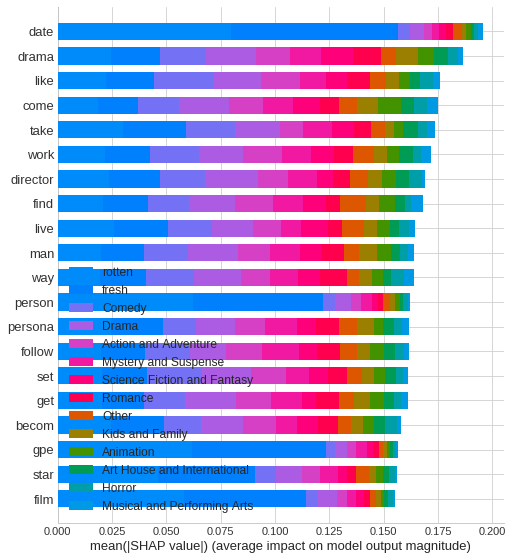

In [33]:
import shap

attrib_data = X_train_pad[:3000]
explainer = shap.DeepExplainer(model, attrib_data)
num_explanations = 50
shap_vals = explainer.shap_values(X_test_pad[:num_explanations])
num2word = {}
for w in tokenizer.word_index.keys():
    num2word[tokenizer.word_index[w]] = w
x_test_words = np.stack([np.array(list(map(lambda x: num2word.get(x, "NONE"), X_test_pad[i]))) for i in range(50)])
shap.summary_plot(shap_vals, class_names=y_df.columns, feature_names=list(num2word.values()))

In [34]:
shap_vals[0].shape

(50, 579)

Action and Adventure


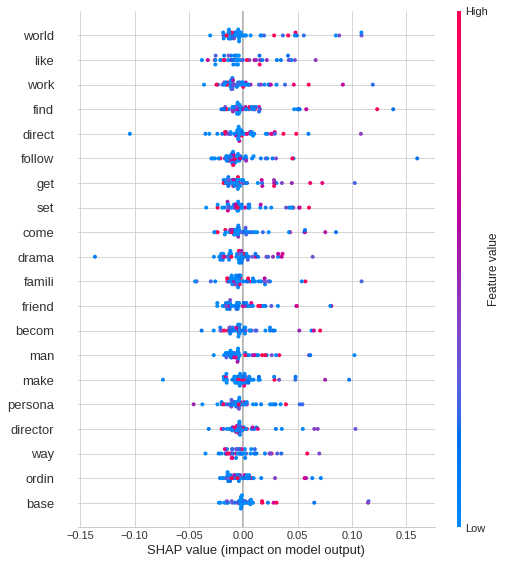

Animation


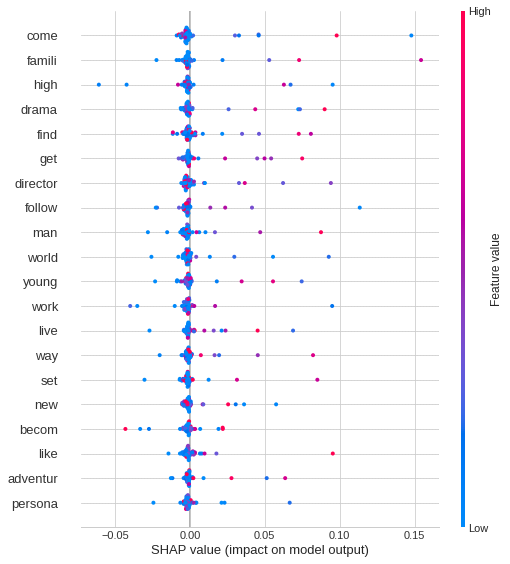

Art House and International


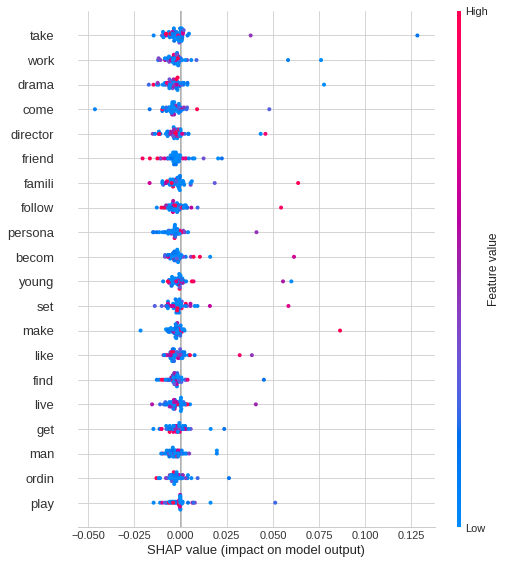

Comedy


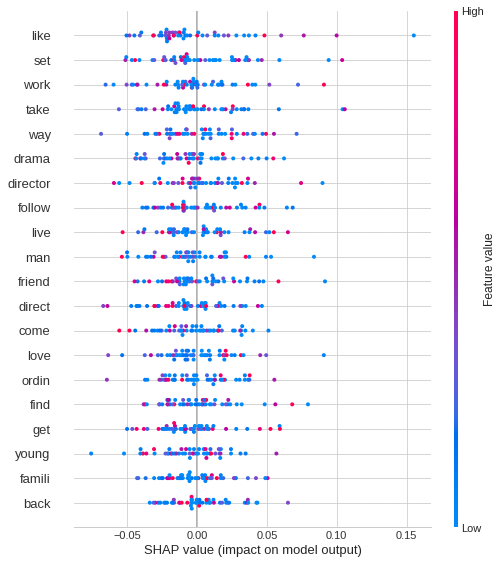

Drama


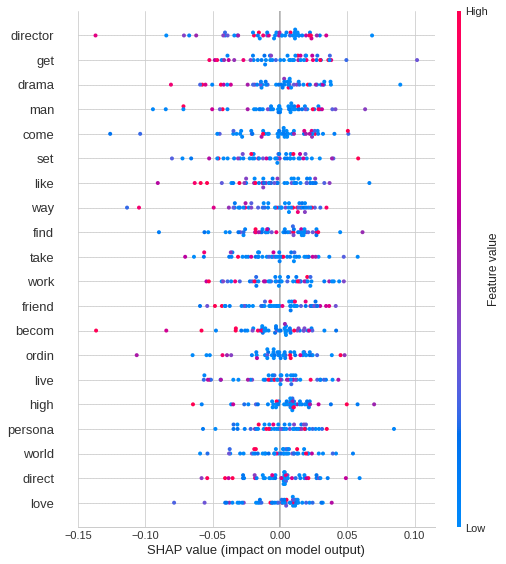

Horror


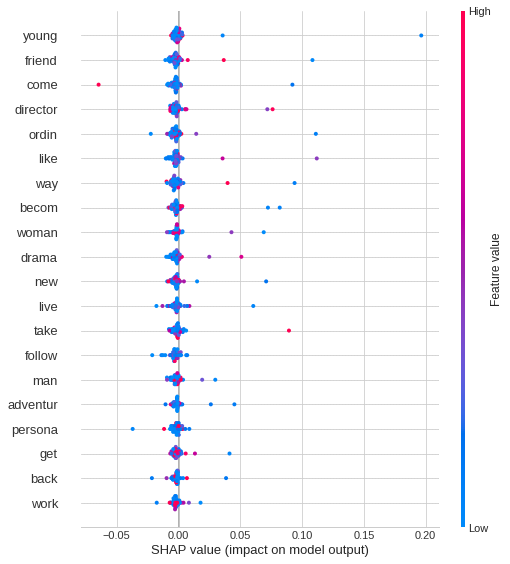

Kids and Family


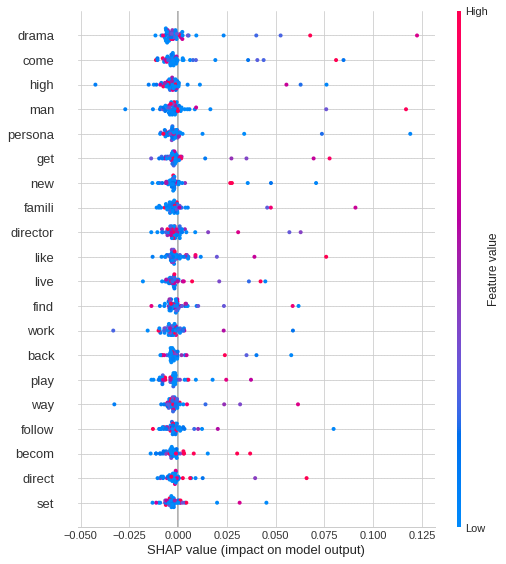

Musical and Performing Arts


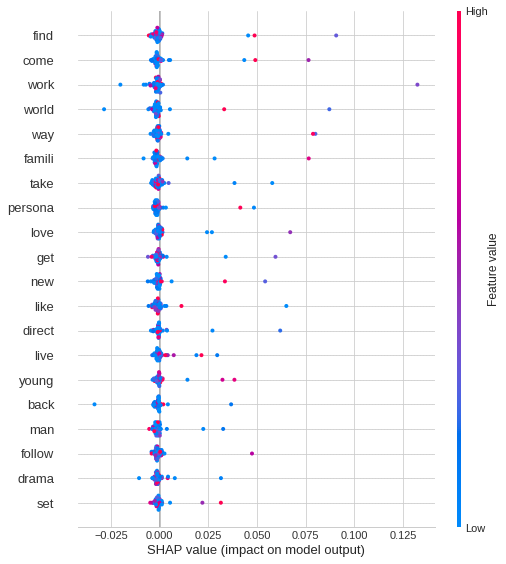

Mystery and Suspense


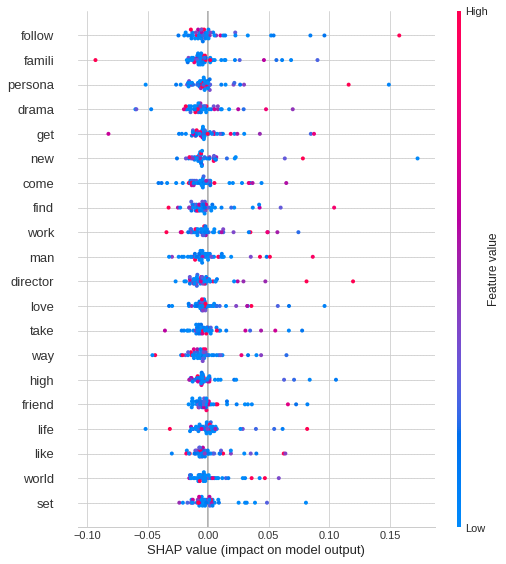

Romance


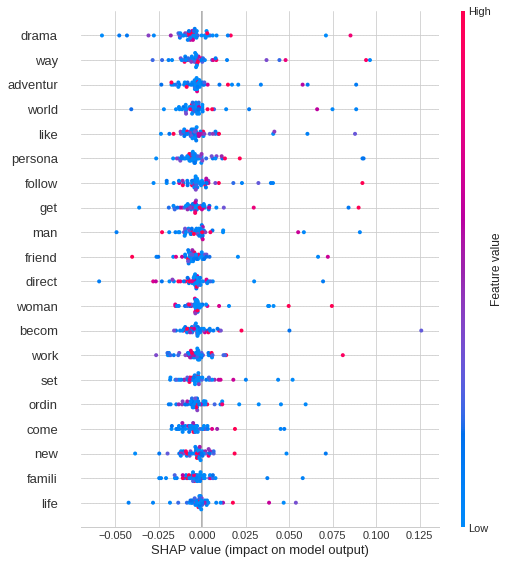

Science Fiction and Fantasy


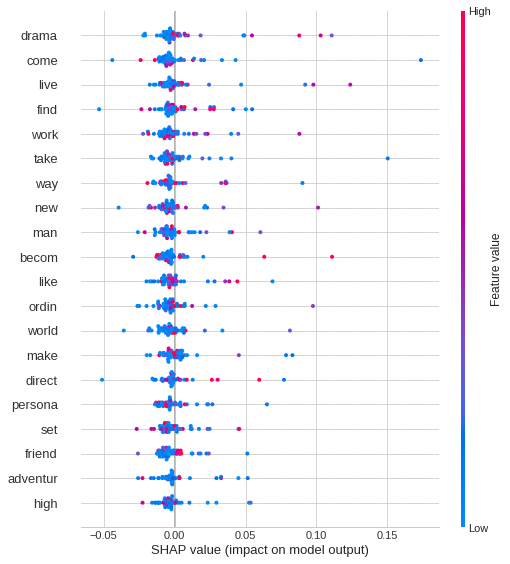

fresh


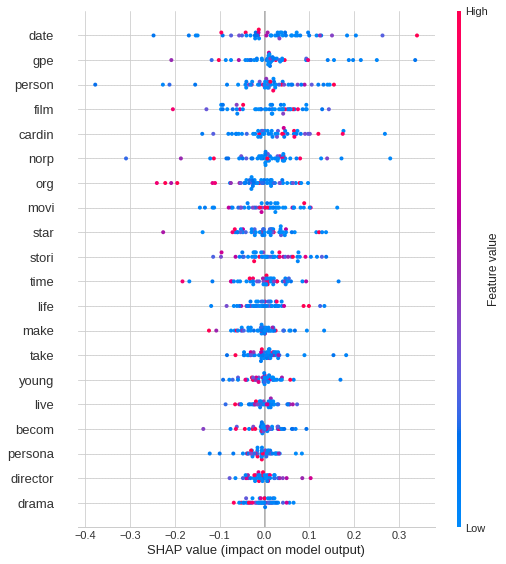

rotten


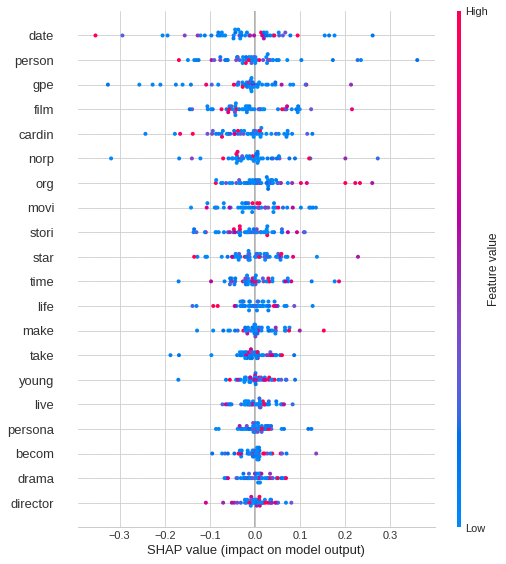

Other


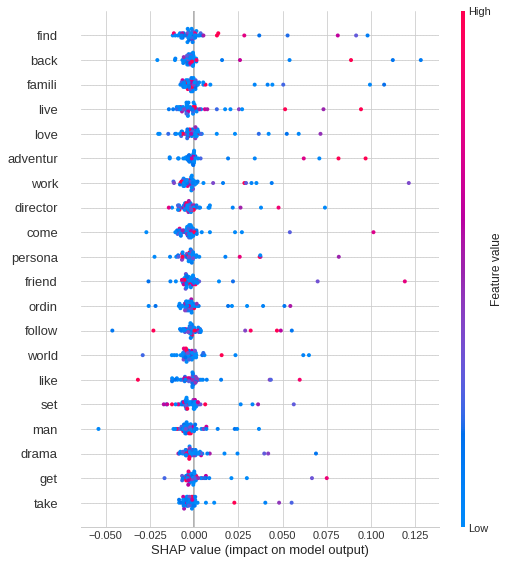

In [35]:
for i in range(14):
    print(y_df.columns[i])
    shap.summary_plot(shap_vals[i], X_test_pad[:num_explanations], feature_names=list(num2word.values()))

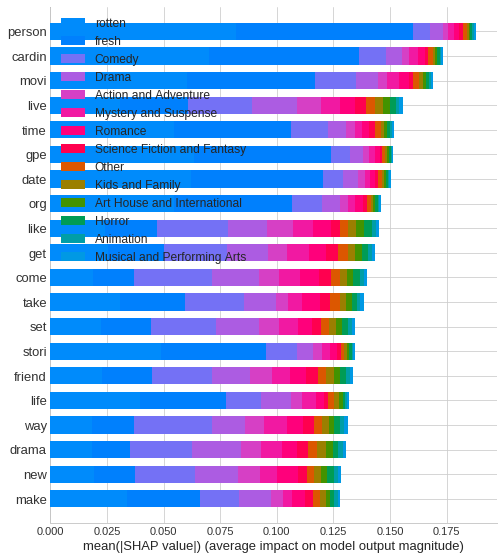

In [36]:
attrib_data = X_train_pad[:5000]
explainer = shap.DeepExplainer(model, attrib_data)
#num_explanations = 50
shap_vals_cdf = explainer.shap_values(selected_exp)
num2word = {}
for w in tokenizer.word_index.keys():
    num2word[tokenizer.word_index[w]] = w
x_test_words = np.stack([np.array(list(map(lambda x: num2word.get(x, "NONE"), selected_exp[i]))) for i in range(50)])
shap.summary_plot(shap_vals_cdf, class_names=y_df.columns, feature_names=list(num2word.values()))

Action and Adventure


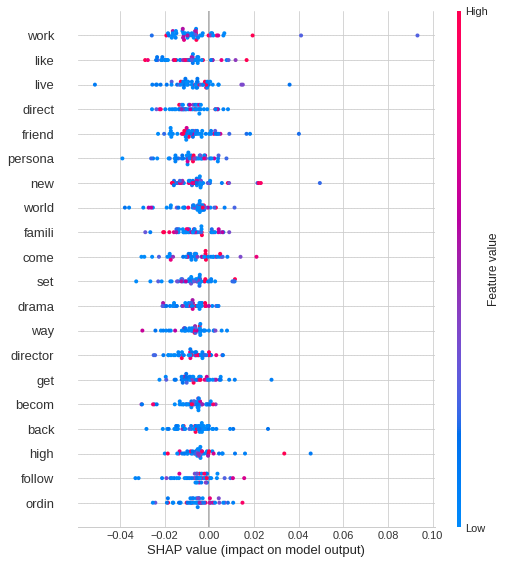

Animation


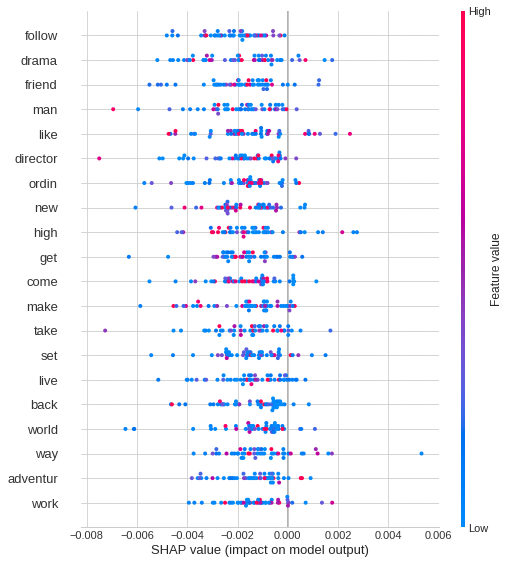

Art House and International


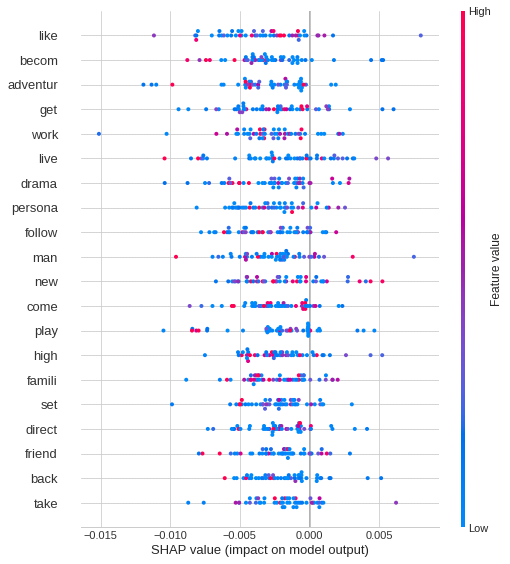

Comedy


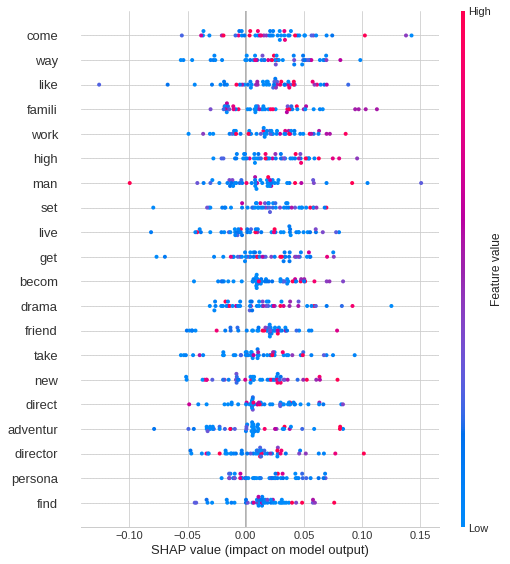

Drama


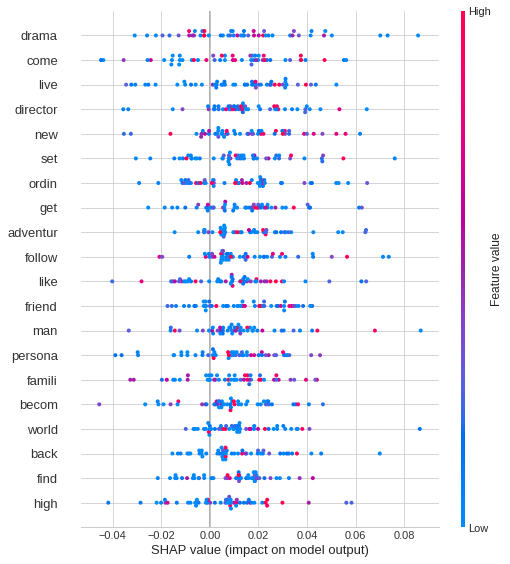

Horror


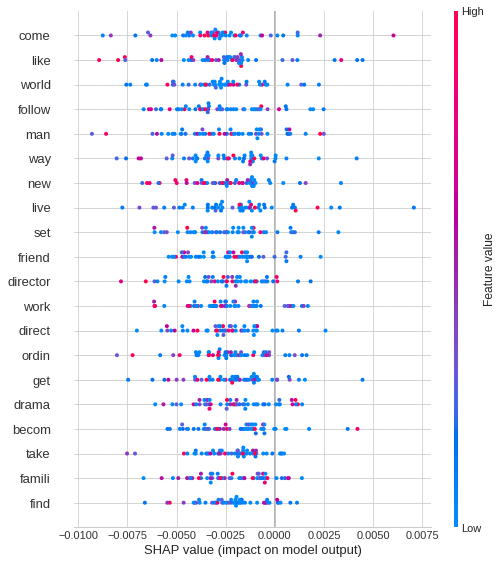

Kids and Family


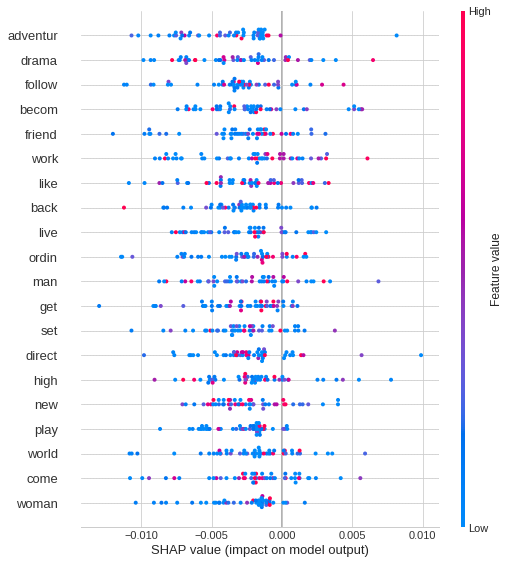

Musical and Performing Arts


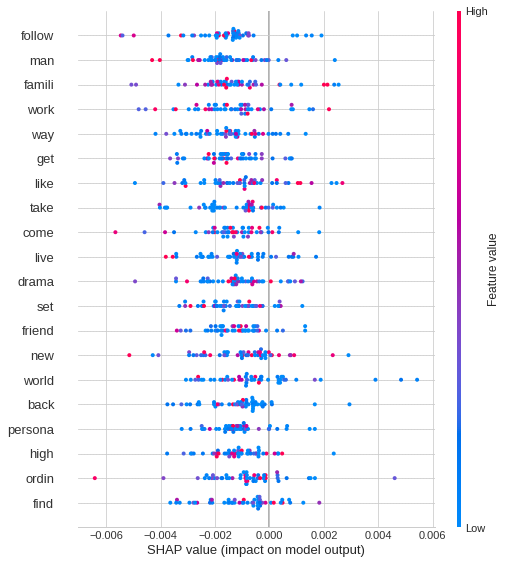

Mystery and Suspense


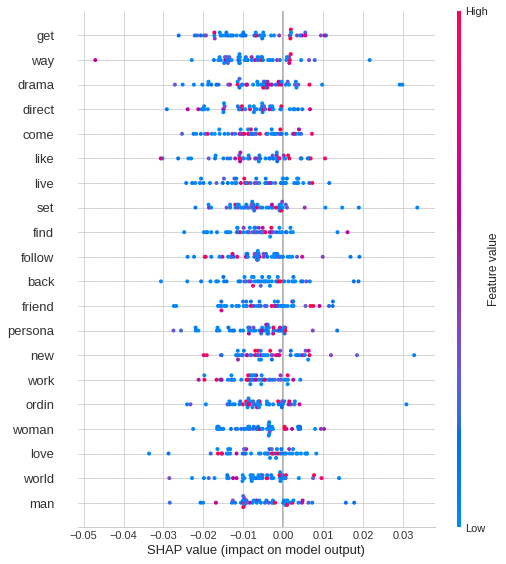

Romance


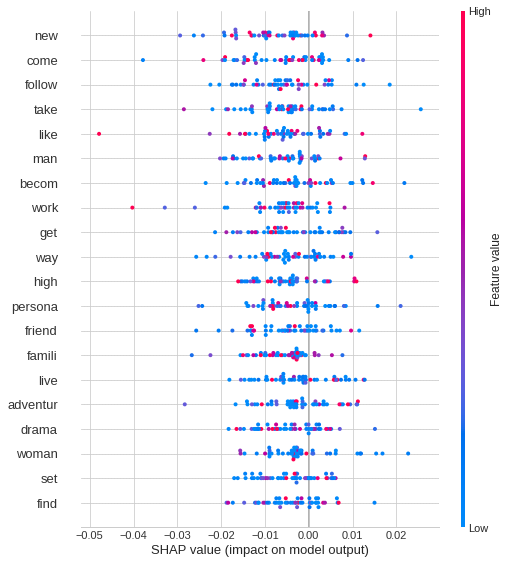

Science Fiction and Fantasy


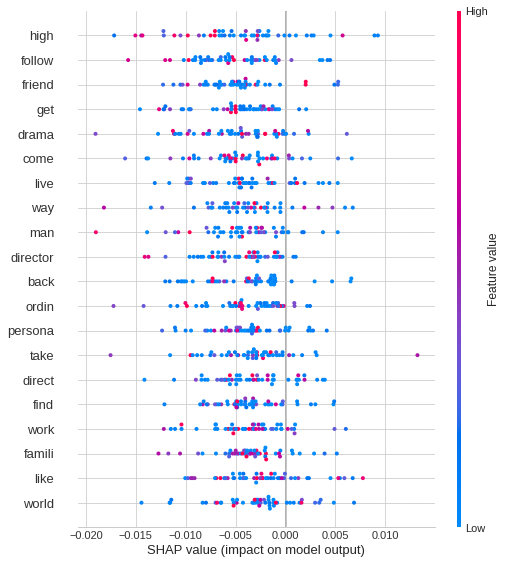

fresh


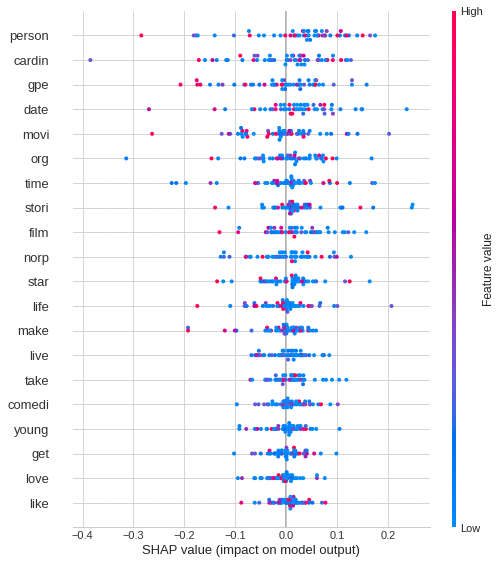

rotten


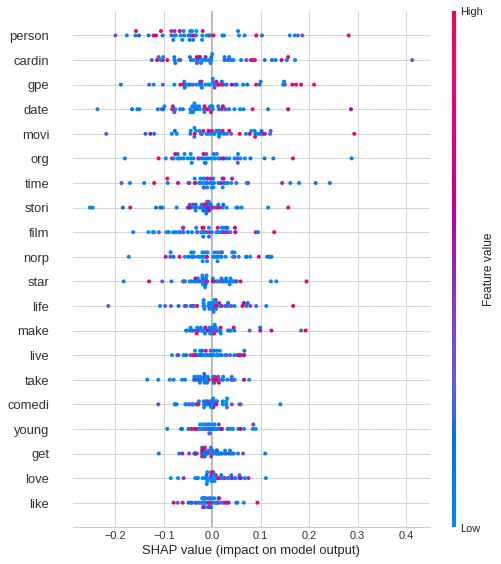

Other


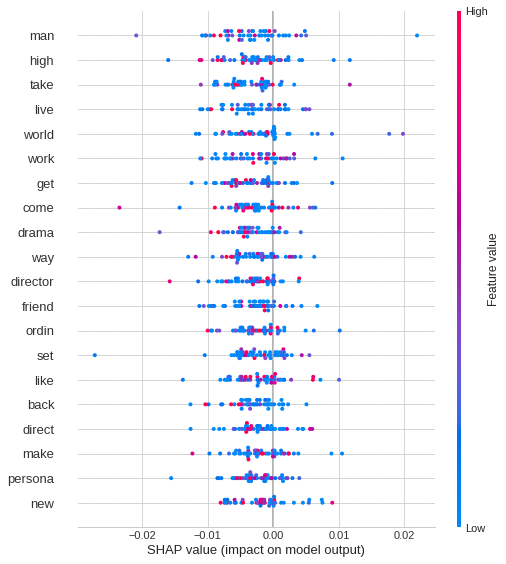

In [37]:
for i in range(14):
    print(y_df.columns[i])
    shap.summary_plot(shap_vals_cdf[i], selected_exp, feature_names=list(num2word.values()))

In [38]:
# init the JS visualization code
shap.initjs()
# create dict to invert word_idx k,v order
num2word = {}
for w in tokenizer.word_index.keys():
    num2word[tokenizer.word_index[w]] = w
x_test_words = np.stack([np.array(list(map(lambda x: num2word.get(x, "NONE"), selected_exp[i]))) for i in range(50)])

# plot the explanation of a given prediction
class_num = 0
input_num = 30
print(tags[0])
shap.force_plot(explainer.expected_value[class_num], shap_vals_cdf[class_num][input_num], x_test_words[input_num])

Action and Adventure


In [39]:
class_num = 1
input_num = 30
print(tags[1])
shap.force_plot(explainer.expected_value[class_num], shap_vals_cdf[class_num][input_num], x_test_words[input_num])

Animation


In [40]:
class_num = 2
input_num = 30
print(tags[2])
shap.force_plot(explainer.expected_value[class_num], shap_vals_cdf[class_num][input_num], x_test_words[input_num])

Art House and International


In [41]:
class_num = 3
input_num = 30
print(tags[3])
shap.force_plot(explainer.expected_value[class_num], shap_vals_cdf[class_num][input_num], x_test_words[input_num])

Comedy


In [42]:
class_num = 4
input_num = 30
print(tags[4])
shap.force_plot(explainer.expected_value[class_num], shap_vals_cdf[class_num][input_num], x_test_words[input_num])

Drama


In [43]:
class_num = 5
input_num = 30
print(tags[5])
shap.force_plot(explainer.expected_value[class_num], shap_vals_cdf[class_num][input_num], x_test_words[input_num])

Horror


In [44]:
class_num = 6
input_num = 30
print(tags[6])
shap.force_plot(explainer.expected_value[class_num], shap_vals_cdf[class_num][input_num], x_test_words[input_num])

Kids and Family


In [45]:
class_num = 7
input_num = 30
print(tags[7])
shap.force_plot(explainer.expected_value[class_num], shap_vals_cdf[class_num][input_num], x_test_words[input_num])

Musical and Performing Arts


In [46]:
class_num = 8
input_num = 30
print(tags[8])
shap.force_plot(explainer.expected_value[class_num], shap_vals_cdf[class_num][input_num], x_test_words[input_num])

Mystery and Suspense


In [47]:
class_num = 9
input_num = 30
print(tags[9])
shap.force_plot(explainer.expected_value[class_num], shap_vals_cdf[class_num][input_num], x_test_words[input_num])

Romance


In [48]:
class_num = 10
input_num = 30
print(tags[10])
shap.force_plot(explainer.expected_value[class_num], shap_vals_cdf[class_num][input_num], x_test_words[input_num])

Science Fiction and Fantasy


In [49]:
class_num = 11
input_num = 30
print(tags[11])
shap.force_plot(explainer.expected_value[class_num], shap_vals_cdf[class_num][input_num], x_test_words[input_num])

fresh


In [50]:
class_num = 12
input_num = 30
print(tags[12])
shap.force_plot(explainer.expected_value[class_num], shap_vals_cdf[class_num][input_num], x_test_words[input_num])

rotten


In [51]:
class_num = 13
input_num = 30
print(tags[13])
shap.force_plot(explainer.expected_value[class_num], shap_vals_cdf[class_num][input_num], x_test_words[input_num])

Other


In [52]:
# or access the embedding layer through the constructed model 
# first `0` refers to the position of embedding layer in the `model`
embeddings = model.layers[0].get_weights()[0]

In [53]:
type(embeddings)

numpy.ndarray

In [54]:
embeddings.shape

(19793, 100)

In [55]:
len(tokenizer.word_index)


19792

In [56]:
embeddings[0]

array([ 5.52950520e-03, -2.55027320e-04,  3.84644372e-03,  6.57119090e-04,
        3.84295615e-03, -5.88651688e-04,  4.41143615e-03, -2.46869936e-03,
       -3.26050003e-03, -1.85428513e-03, -3.33381235e-03, -3.30356020e-03,
        1.26931572e-03,  9.30682872e-04,  1.41483569e-03, -4.70464490e-03,
       -4.92357532e-04, -4.13114158e-03, -4.59817285e-03, -1.91618863e-03,
        2.94863363e-04,  5.53816091e-03,  5.69319469e-04,  2.21295306e-03,
       -3.36061371e-03, -7.71586318e-03,  2.82437610e-03,  4.52853681e-04,
        1.30235991e-02,  3.30463168e-04,  2.28183996e-03,  4.96012438e-03,
        5.81392692e-03, -4.37270757e-03,  4.08978574e-03, -1.74783485e-03,
       -3.46503058e-03,  3.99882765e-03, -4.18476434e-03, -4.21597296e-03,
        4.37165052e-03, -3.34987324e-03, -2.08973885e-03, -1.76832359e-03,
        5.40647481e-04,  1.99027127e-04,  5.74469380e-03, -5.15751541e-04,
        3.07432609e-03,  1.49550603e-03, -2.05730950e-03, -1.21250255e-02,
        3.42628779e-03,  

In [57]:
X_train_pad[0].shape

(579,)

In [58]:
X_train_pad[0]

array([2227,   95,   47, 2059,  336,   15,  187,  215, 2049, 5602,  142,
         41, 5139,  515,  294, 1812, 2725,  198,   39,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [59]:
word_lookup = {v:k for k,v in tokenizer.word_index.items()}

In [62]:
word_lookup[2227]

'refresh'

In [64]:
for i in X_train_pad[0]:
    if i != 0:
        print(word_lookup[i])
    else:
        print('<PAD>')

refresh
see
charact
practic
believ
make
entertain
watch
definit
faint
heart
woman
stack
odd
manag
stick
inde
give
back
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>